In [38]:
import pandas as pd
import numpy as np
import math
import random
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import datetime

In [2]:
filename = "sap_storing_data_hu_project.csv" 
df_not_cleaned = pd.read_csv(filename, low_memory=False)
#verwijder alle kolommen die niet van gebruik zijn:
df = df_not_cleaned.drop(columns=['stm_sap_mon_meld_ddt', 'stm_mon_begin_ddt', 'stm_mon_toelichting_trdl', 'stm_oh_pg_mld', 'stm_geo_mld_uit_functiepl', 'stm_scenario_mon', 'stm_status_melding_sap', 'stm_mon_nr_status_omschr', 'stm_mon_nr__statuscode', 'stm_mon_nr_status_wijzdd', 'stm_aanntpl_ddt', 'stm_geo_gst_uit_functiepl', 'stm_objectdl_code_gst', 'stm_objectdl_groep_gst', 'stm_progfh_in_ddt', 'stm_progfh_in_invoer_ddt', 'stm_progfh_gw_ddt', 'stm_progfh_gw_lwd_ddt', 'stm_progfh_hz', 'stm_veroorz_groep', 'stm_veroorz_code', 'stm_progfh_gw_duur', 'stm_progfh_gw_lwd_tijd', 'stm_progfh_gw_lwd_datum', 'stm_progfh_gw_datum', 'stm_arbeid', 'stm_functiepl_gst', 'stm_functiepl_mld', 'stm_mon_begintijd', 'stm_mon_begindatum', 'stm_aangelegd_tijd', 'stm_aangelegd_dd', 'stm_dir_betrok_tr', 'stm_evb', 'stm_mon_vhdsincident', 'stm_mon_eind_ddt', 'stm_afspr_aanvangddt', 'stm_effect', 'stm_veroorz_tekst_kort', 'stm_projnr', 'stm_wbi_nummer', 'stm_status_gebr', 'stm_standplaats', 'stm_actie', 'stm_hinderwaarde', 'stm_rec_toegev_ddt', 'stm_afsluit_tijd', 'stm_afsluit_dd', 'stm_afsluit_ddt', 'stm_akkoord_melding_jn', 'stm_fact_jn', 'stm_status_sapnaarmon', 'stm_akkoord_mon_toewijz', 'stm_controle_dd', 'stm_mon_eind_tijd', 'stm_mon_eind_datum', 'stm_reactie_duur', 'stm_afspr_aanvangtijd', 'stm_afspr_aanvangdd', 'stm_historie_toelichting', 'stm_schade_verhaalb_jn', 'stm_x_bron_arch_dt', 'stm_x_bron_bestandsnaam', 'stm_x_bron_publ_dt', 'stm_rapportage_jaar', 'stm_rapportage_maand', 'stm_sorteerveld', 'stm_afspr_func_hersteltijd', 'stm_afspr_func_hersteldd', 'stm_relatiervo', 'stm_relatiervo_volgend', 'stm_relatiervo_vorig', 'stm_schade_statusdatum', 'stm_schade_status_ga', 'stm_schadenr', 'stm_x_start_sessie_dt', 'stm_x_bk', 'stm_x_run_id', 'stm_x_actueel_ind', 'stm_x_vervallen_ind'])
print("Done")

Done


# Data cleaning:


De te bepalen welke variabelen het meest van toepassing zijn om te gebruiken kijken we naar welke
kolommen informatie geven over de tijd van de melding, monteur. Tijd wanneer de melding word opgelost.
Wat voor melding het is en info over de melding/storing, en de locatie. Zo zijn de volgende kolommen
het meest van toepassing:

Over soort melding
- stm_sap_meldtekst (melding omschrijving)
- stm_geo_mld (melding code) - nodig
- stm_oorz_code (oorzaak code) - nodig
- stm_prioriteit (prioriteit)

Over tijd:
- stm_sap_melddatum (datump melding) - nodig
- stm_sap_meldtijd (tijdstip melding) - nodig
- stm_aanngeb_dd (datum aannemer gebeld)
- stm_aanngeb_tijd (tijd aannemer gebeld)
- stm_aanntpl_dd (datum aannemer op plek)
- stm_aanntpl_tijd (tijd aannemer op plek)

- stm_fh_dd (Datum van functie herstel) - nodig
- stm_fh_tijd (Tijdstip van functieherstel) - nodig
- stm_sap_storeinddatum (Datum einde storing) - nodig
- stm_sap_storeindtijd (Tijdstip einde storing) - nodig
- stm_fh_duur (Duur van functiehersteltijd) - nodig

Over equipment:
- stm_equipm_nr_mld (equipment)
- stm_equipm_omschr_mld (equipment omschrijving)

Over locatie
- stm_km_van_mld (locatie van)
- stm_km_tot_mld (locatie tot)
- stm_vl_post (VL post) - nodig
- stm_contractgeb_mld(locatie melding) - nodig
- stm_pplg_van (PPLG van locatie)
- stm_pplg_naar (PPLG tot locatie)
- stm_dstrglp_van (Dienstregelpunt van locatie)
- stm_dstrglp_naar (Dienstregelpunt tot locatie)

Over prognose:
- stm_progfh_in_datum (Datum prognose)
- stm_progfh_in_tijd (Tijdstip FHT prognose)
- stm_progfh_in_invoer_dat (Invoer datum prognose)
- stm_progfh_in_invoer_tijd (Invoer tijdstip FHT prognose)
- stm_progfh_in_duur (Duur FHT)



In [3]:
#deze functie verwijdert alle rijen waar geen value op de gegeven kolommen zitten
def drop_rows_with_null(lst, df):
    dfisnull = df.isnull()[lst]
    matches = dfisnull[(dfisnull).any(axis=1)]
    return df.drop(matches.index)

In [4]:
#Deze functie berkent de uitschiet grenzen
def uitschieters_bereken(kolom):
    q1 = kolom.quantile(0.25)
    q3 = kolom.quantile(0.75)
    iqr = q3 - q1
    maxuitschieter = q3 + (iqr*1.5)
    minuitschieter = q1 - (iqr*1.5)
    return maxuitschieter, minuitschieter

#Deze functie geeft de indexes van uitschieters in een kolom
def return_uitschieters_indexes(kolom):
    maxuitschieter = uitschieters_bereken(kolom)[0]
    minuitschieter = uitschieters_bereken(kolom)[1]
    uitschieters = [kolom[kolom > maxuitschieter].index, kolom[kolom < minuitschieter].index]
    return uitschieters
    
#Deze functie geeft een kolom zonder uitschieters
def return_kolom_zonder_uitschieters(kolom):
    maxuitschieter = uitschieters_bereken(kolom)[0]
    minuitschieter = uitschieters_bereken(kolom)[1]
    kolom = kolom[kolom < maxuitschieter][kolom > minuitschieter]
    return kolom


In [5]:
#Deze functie berkent de extreme uitschiet grenzen
def ex_uitschieters_bereken(kolom):
    q1 = kolom.quantile(0.25)
    q3 = kolom.quantile(0.75)
    iqr = q3 - q1
    maxuitschieter = q3 + (iqr*3)
    minuitschieter = q1 - (iqr*3)
    return maxuitschieter, minuitschieter

#Deze functie geeft de indexes van extreme uitschieters in een kolom
def return_ex_uitschieters_indexes(kolom):
    maxuitschieter = uitschieters_ex_bereken(kolom)[0]
    minuitschieter = uitschieters_ex_bereken(kolom)[1]
    uitschieters = [kolom[kolom > maxuitschieter].index, kolom[kolom < minuitschieter].index]
    return uitschieters
    
#Deze functie geeft een kolom zonder extreme uitschieters
def return_kolom_zonder_ex_uitschieters(kolom):
    maxuitschieter = uitschieters_ex_bereken(kolom)[0]
    minuitschieter = uitschieters_ex_bereken(kolom)[1]
    kolom = kolom[kolom < maxuitschieter][kolom > minuitschieter]
    return kolom



In [6]:
# Verwijder de rijen die geen value bevatten in de benodigde kolommen
df_filtered = drop_rows_with_null(['stm_geo_mld', 'stm_sap_melddatum', 'stm_oorz_code', 'stm_sap_meldtijd',
                          'stm_fh_dd', 'stm_fh_tijd', 'stm_sap_storeinddatum', 'stm_sap_storeindtijd',
                          'stm_fh_duur', 'stm_vl_post', 'stm_contractgeb_mld'], df)
print(len(df))
print(len(df_filtered))
df_filtered

898526
132923


,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_meldtekst_lang,stm_sap_meldtekst,stm_geo_mld,stm_equipm_nr_mld,stm_equipm_soort_mld,...,stm_fh_dd,stm_fh_tijd,stm_fh_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_oorz_tekst_kort,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar
85,87,50053389,37.0,EHV,10/01/2006 16:11:00,Logboeknr RBV : 37 Tijd: 1611 VL-Post: ...,Logboeknr RBV : 37 Tijd: 1611 VL-P,618.0,10646141.0,SYSTBOVENL,...,10/01/2006,16:31:00,20.0,11/01/2006,10:33:00,Geen SMC-melding. Afwijzing. Bij het SMC,NaN,NaN,EHV,NaN
123,125,50053438,62.0,AH,15/01/2006 23:08:00,Logboeknr RBV : 62 Tijd: 2308 VL-Post: ...,Logboeknr RBV : 62 Tijd: 2308 VL-P,514.0,10201441.0,WISSEL,...,15/01/2006,23:20:00,12.0,15/01/2006,23:20:00,NaN,NaN,NaN,Nm,NaN
205,208,50053591,39.0,EHV,20/01/2006 14:32:00,Logboeknr RBV : 39 Tijd: 1432 VL-Post: ...,Logboeknr RBV : 39 Tijd: 1432 VL-P,515.0,10527838.0,WISSEL,...,20/01/2006,14:47:00,15.0,23/01/2006,11:39:00,Geen SMC-melding.,NaN,NaN,Vga,NaN
226,229,50053628,250.0,ZL,24/01/2006 20:20:00,Logboeknr RBV : 250 Tijd: 2020 VL-Post: ...,Logboeknr RBV : 250 Tijd: 2020 VL-P,25.0,10211614.0,OVERWEG,...,24/01/2006,20:30:00,10.0,24/01/2006,20:30:00,NaN,NaN,NaN,AMRI,NaN
240,243,50053652,42.0,RSD,25/01/2006 09:30:00,Logboeknr RBV : 42 Tijd: 0930 VL-Post: ...,Logboeknr RBV : 42 Tijd: 0930 VL-P,127.0,10621371.0,DETECTREIN,...,25/01/2006,09:44:00,14.0,30/01/2006,11:21:00,Geen SMC-melding.Geen onderzoek geweest.,NaN,NaN,Arn,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
898413,908517,99003207,3669429.0,MT,21/05/2016 13:17:56,[2+] Mtr-Edng : Sp-Sb/TB t.o.b.s. alle ovw'en ...,[2+] Mtr-Edng : Sp-Sb/TB t.o.b.s. alle o,71.0,10621358.0,DETECTREIN,...,21/05/2016,14:35:00,175.0,21/05/2016,14:50:00,Gestoord object: SECTIE 913AT. Gestoord,MTR,NaN,MTR,EDN
898472,908576,99003486,1995699.0,RTD,10/05/2013 17:54:00,"Brd : deuren buis 2, 3, 4 en open tijdens tre...","Brd : deuren buis 2, 3, 4 en open tijden",116.0,10590754.0,TUNCONSTR,...,10/05/2013,19:38:00,104.0,10/05/2013,20:40:00,NaN,RTST,NaN,RTST,RLB
898473,908577,99003486,1995699.0,RTD,10/05/2013 17:54:00,"Brd : deuren buis 2, 3, 4 en open tijdens tre...","Brd : deuren buis 2, 3, 4 en open tijden",116.0,10590754.0,TUNCONSTR,...,10/05/2013,19:38:00,104.0,10/05/2013,20:40:00,NaN,RTST,NaN,RTST,RLB
898474,908578,99003486,1995699.0,RTD,10/05/2013 17:54:00,"Brd TTI: deuren buis 2, 3, 4 en open tijdens ...","Brd TTI: deuren buis 2, 3, 4 en open tij",116.0,10590754.0,TUNCONSTR,...,10/05/2013,19:38:00,104.0,10/05/2013,20:40:00,NaN,RTST,NaN,RTST,RLB


In [7]:
#uitgeschreven lijsten zodat ik ze niet steeds hoef over te typen

# melding
df[['stm_sap_meldtekst', 'stm_geo_mld', 'stm_oorz_code', 'stm_prioriteit']]
# tijd
df[['stm_sap_melddatum', 'stm_sap_meldtijd', 'stm_aanngeb_dd', 'stm_aanngeb_tijd', 'stm_aanntpl_dd', 'stm_aanntpl_tijd']]
df[['stm_fh_dd', 'stm_fh_tijd', 'stm_fh_duur', 'stm_sap_storeinddatum', 'stm_sap_storeindtijd']]
# equipment
df[['stm_equipm_omschr_mld', 'stm_equipm_nr_mld']]
# locatie
df[['stm_km_van_mld', 'stm_km_tot_mld', 'stm_vl_post', 'stm_contractgeb_mld', 'stm_pplg_van', 'stm_pplg_naar', 'stm_dstrglp_van', 'stm_dstrglp_naar']]
# prognose
df[['stm_progfh_in_datum', 'stm_progfh_in_tijd', 'stm_progfh_in_invoer_dat', 'stm_progfh_in_invoer_tijd', 'stm_progfh_in_duur']]


,stm_progfh_in_datum,stm_progfh_in_tijd,stm_progfh_in_invoer_dat,stm_progfh_in_invoer_tijd,stm_progfh_in_duur
0,NaN,NaN,NaN,NaN,NaN
1,NaN,00:00:00,NaN,00:00:00,99999999.0
2,NaN,00:00:00,NaN,00:00:00,99999999.0
3,NaN,00:00:00,NaN,00:00:00,99999999.0
4,NaN,00:00:00,NaN,00:00:00,99999999.0
...,...,...,...,...,...
898521,11/05/2013,09:35:00,11/05/2013,09:26:18,30
898522,11/05/2013,11:00:00,11/05/2013,10:16:27,52
898523,11/05/2013,11:00:00,11/05/2013,10:16:27,52
898524,20/08/2016,16:00:00,20160820,15:16:29,75


# Baseline
Target variabele is 'stm_fh_duur'. Dit is de functie hersteltijd dit houd in dat vanaf de melding tot dat het probleem opgelost is getimed wordt. 

baseline:  

In [15]:
# De target variabele filteren tussen de 0 min en 360 min. Prodcut ower gaf dit als grens aan. 
data_fht = df_filtered['stm_fh_duur'].loc[(df_filtered['stm_fh_duur'] > 0) & (df_filtered['stm_fh_duur'] < 360)]
data_fht

85         20.0
123        12.0
205        15.0
226        10.0
240        14.0
          ...  
898413    175.0
898472    104.0
898473    104.0
898474    104.0
898475    104.0
Name: stm_fh_duur, Length: 108985, dtype: float64

In [16]:
data_fht.describe()

count    108985.000000
mean        101.654897
std          74.588694
min           1.000000
25%          50.000000
50%          82.000000
75%         134.000000
max         359.000000
Name: stm_fh_duur, dtype: float64

In [17]:
data_fht.mean()

101.65489746295361

In [18]:
data_fht.median()

82.0

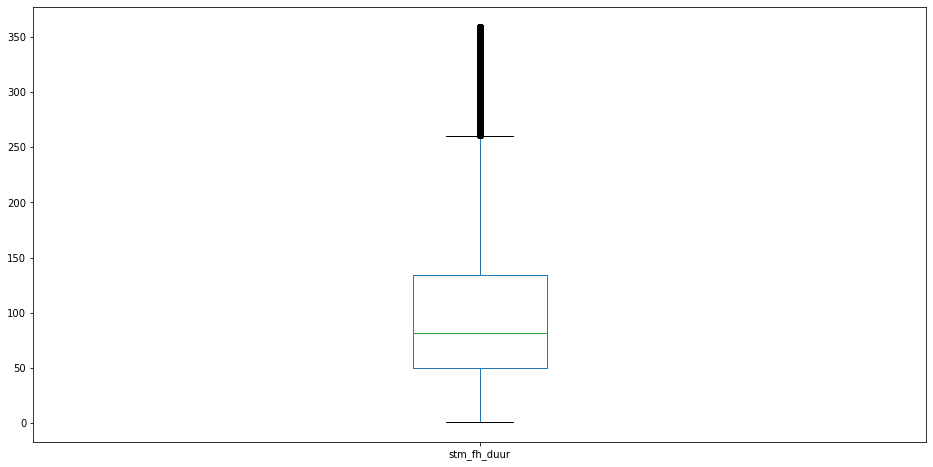

In [19]:
data_fht.plot.box(figsize=(16,8))

In [20]:
len(data_fht[data_fht < data_fht.mean()])

66792

In [21]:
len(data_fht[data_fht < data_fht.mean()])/len(data_fht)*100

61.28549800431252

In [22]:
len(data_fht[data_fht < data_fht.median()])/len(data_fht)*100

49.46093499105381

61% van alle herstel tijden zit onder het gemiddelde 102 min

50% van alle herstel tijden zit onder de mediaan 82 min



In [24]:
data_fht = data_fht.to_frame()
data_fht['mediaan'] = data_fht['stm_fh_duur'].median()
data_fht['mean'] = data_fht['stm_fh_duur'].mean()
data_fht.head()

,stm_fh_duur,mediaan,mean
85,20.0,82.0,101.654897
123,12.0,82.0,101.654897
205,15.0,82.0,101.654897
226,10.0,82.0,101.654897
240,14.0,82.0,101.654897


In [25]:
# de score bepalen aan de hand van de RSME
np.sqrt(mean_squared_error(data_fht.loc[:,'stm_fh_duur'],data_fht.loc[:,'mean']))

74.58835193775484

In [26]:
#de score bepalen aan de hand van de RSME
np.sqrt(mean_squared_error(data_fht.loc[:,'stm_fh_duur'],data_fht.loc[:,'mediaan']))

77.13453985776798

# KNeighborsregression

In [39]:
#data cleaning
data_KN = df_filtered[['stm_km_van_mld', 'stm_prioriteit']]

In [40]:
df_filtered['stm_sap_meld_ddt'] = df_filtered['stm_sap_meld_ddt'].apply(pd.to_datetime)

In [41]:
df_year = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.year)
df_filtered.insert(5, 'Jaar', df_year)

In [42]:
df_day = pd.DataFrame(df_filtered['stm_sap_meld_ddt'].dt.dayofyear)
df_filtered.insert(6, 'Dag_van_jaar', df_day)

In [49]:
df_fhd = pd.DataFrame(df_filtered['stm_fh_duur'].loc[(df_filtered['stm_fh_duur'] > 0) & (df_filtered['stm_fh_duur'] < 360)])
df_filtered.insert(7, 'fht_filtered', df_fhd)

In [50]:
data_KN = df_filtered[['stm_km_van_mld', 'stm_prioriteit','Jaar','Dag_van_jaar', 'stm_fh_duur','fht_filtered' ]]
data_KN

,stm_km_van_mld,stm_prioriteit,Jaar,Dag_van_jaar,stm_fh_duur,fht_filtered
85,0.0,4.0,2006,274,20.0,20.0
123,0.0,9.0,2006,15,12.0,12.0
205,0.0,9.0,2006,20,15.0,15.0
226,0.0,9.0,2006,24,10.0,10.0
240,0.0,9.0,2006,25,14.0,14.0
...,...,...,...,...,...,...
898413,0.0,2.0,2016,142,175.0,175.0
898472,39193.0,1.0,2013,278,104.0,104.0
898473,39193.0,1.0,2013,278,104.0,104.0
898474,39193.0,1.0,2013,278,104.0,104.0


# linear regression 

In [ ]:
afstand = ['stm_km_tot_mld']
tijd = ['stm_fh_duur']
X= df_filtered[afstand]
y= df_filtered[tijd]

In [ ]:
# de data splitsen in training en testing data
from sklearn.model_selection import train_test_split
# test_size
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.25, random_state=None) 

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
linear_reg_model = LinearRegression()

In [ ]:
linear_reg_model.fit(X_train, y_train)

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred_test = linear_reg_model.predict(X_test)

error_metric = mean_squared_error(y_pred=y_pred_test, y_true=y_test)
print(error_metric)

# extra tree classifier

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

In [ ]:
afstand = ['stm_km_tot_mld']
tijd = ['stm_fh_duur']
X= df_filtered[afstand]
y= df_filtered[tijd].values.ravel()

In [ ]:
# de data splitsen in training en testing data
from sklearn.model_selection import train_test_split
# test_size
X_train, X_test, y_train,y_test = train_test_split(X,y, test_size=0.25, random_state=None) 

In [ ]:
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)

In [ ]:
X_test

In [ ]:
y_test

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
clf.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix 

In [ ]:
confusion_matrix(list(y_test), clf.predict(X_test))

In [ ]:
accuracy_score(list(y_test), clf.predict(X_test))

In [ ]:
y.shape

In [ ]:
X.shape